## Step 3: make your classifier

### Background

Transcription factors are proteins that bind DNA at promoters to drive gene expression. Most preferentially bind to specific sequences while ignoring others. Traditional methods to determine these sequences (called motifs) have assumed that binding sites in the genome are all independent. However, in some cases people have identified motifs where positional interdependencies exist.

### Your task

You will implement a multi-layer fully connected neural network using your NeuralNetwork class to predict whether a short DNA sequence is a binding site for the yeast transcription factor Rap1. The training data is incredibly imbalanced, with way fewer positive sequences than negative sequences, so you will implement a sampling scheme to ensure that class imbalance does not affect training. As in step 2, all of the following work should be done in a Jupyter Notebook.

### To-do

 - Use the read_text_file function from io.py to read in the 137 positive Rap1 motif examples.
 - Use the read_fasta_file function from io.py to read in all the negative examples. Note that these sequences are much longer than the positive sequences, so you will need to process them to the same length.
 - Balance your classes using your sample_seq function and explain why you chose the sampling scheme you did.
 - One-hot encode the data using your one_hot_encode_seqs function.
 - Split the data into training and validation sets.
 - Generate an instance of your NeuralNetwork class with an appropriate architecture.
 - Train your neural network on the training data.
 - Plot your training and validation loss by epoch.
 - Report the accuracy of your classifier on your validation dataset.
 - Explain your choice of loss function and hyperparameters.

#### Imports and helper functions

In [652]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from typing import List, Dict, Tuple, Union
from numpy.typing import ArrayLike
from nn import io
import re
from collections import Counter
from nn.nn import NeuralNetwork
import matplotlib.pyplot as plt
import seaborn as sns
import time
from nn import preprocess

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [587]:
# timing function
def display_run_time(s,e,task):
    rt=(e-s)
    if rt>=60:
        rt=rt/60
        print(f"{task}: {rt} m")
    else:
        print(f"{task}: {rt} s")

#### Load data

In [588]:
# read txt file of sequences
pos_seqs=io.read_text_file("./data/rap1-lieb-positives.txt")
neg_seqs=io.read_fasta_file("./data/yeast-upstream-1k-negative.fa")

#### Process negative sequences

In order to process the longer negative sequences, we will take k-mers of each negative sequence with the _k_ set to the length of a positive sequence.

In [589]:
# split each negative sequence into kmers 
seq_length=len(pos_seqs[0])
neg_seqs_kmers=[]
for neg_seq in neg_seqs:
    for idx, _ in enumerate(neg_seq):
        neg_seq_kmer=neg_seq[idx:idx+seq_length]
        if (len(neg_seq_kmer)==seq_length):
            neg_seqs_kmers.append(neg_seq_kmer)
        else:
            break

#### Get balanced samples and encode

The sampling strategy takes all of the positive classes and randomly samples the same number of negative classes. A batch-like method can be employed to get an even distribution across all of the negative samples as well. 

In [590]:
# aggregate all seqs and labels and sample
all_seqs=pos_seqs+neg_seqs_kmers
all_labels=[True]*len(pos_seqs)+[False]*len(neg_seqs_kmers)
sampled_seqs, sampled_labels=preprocess.sample_seqs(all_seqs, all_labels)

# print classes
print("Sample label counts: ", Counter(sampled_labels))

# encode seqs
sampled_seqs_encoded=preprocess.one_hot_encode_seqs(sampled_seqs)

# convert to arrays
sampled_seqs_encoded=np.array(sampled_seqs_encoded)
sampled_labels=np.array(sampled_labels)

# print dimensions
print("Sample seqs dimensions: ", sampled_seqs_encoded.shape)
print("Sample label dimensions: ", sampled_labels.shape)

Sample label counts:  Counter({True: 137, False: 137})
Sample seqs dimensions:  (274, 68)
Sample label dimensions:  (274,)


#### Initialize NN and split data for training/validation

In [653]:
# initialize neural network and set hyperparameters
nn_arch = [
    {"input_dim": 68, "output_dim": 136, "activation": "relu"},
    {"input_dim": 136, "output_dim": 136, "activation": "relu"},
    {"input_dim": 136, "output_dim": 136, "activation": "relu"},
    {"input_dim": 136, "output_dim": 68, "activation": "relu"},
    {"input_dim": 68, "output_dim": 34, "activation": "relu"},
    {"input_dim": 34, "output_dim": 1, "activation": "sigmoid"},
]
    # {"input_dim": 17, "output_dim": 5, "activation": "sigmoid"},
    # {"input_dim": 5, "output_dim": 1, "activation": "sigmoid"}


lr=0.1
seed=5348
batch_size=35
epochs=1000
loss_function='bce'
nn=NeuralNetwork(nn_arch, lr=lr, seed=seed, batch_size=batch_size, epochs=epochs, loss_function=loss_function) # loss function can be mse or bce

In [654]:
# get training and validation sets, the sample_seqs_encoded are initially batches along the rows and features along the columns
X_train, X_val, y_train, y_val=train_test_split(sampled_seqs_encoded, sampled_labels, test_size=0.3, random_state=354)

# print dimensions
print("X_train dimensions: ", X_train.shape)
print("X_val dimensions: ", X_val.shape)

X_train dimensions:  (191, 68)
X_val dimensions:  (83, 68)


#### Train model and get the loss history

In [655]:
# train the model
start_time=time.time()
per_epoch_loss_train, per_epoch_loss_val=nn.fit(X_train, y_train, X_val, y_val)
end_time=time.time()
display_run_time(start_time,end_time,f"Training NN RT (lr: {lr}, batch_size: {batch_size}, epochs: {epochs}, loss_function: {loss_function}")

y_hat_train (35, 1)
y_hat_train_for_loss (35, 1)
y_train_batch (35, 1)
y_hat_train (35, 1)
y_hat_train_for_loss (35, 1)
y_train_batch (35, 1)
y_hat_train (35, 1)
y_hat_train_for_loss (35, 1)
y_train_batch (35, 1)
y_hat_train (35, 1)
y_hat_train_for_loss (35, 1)
y_train_batch (35, 1)
y_hat_train (35, 1)
y_hat_train_for_loss (35, 1)
y_train_batch (35, 1)
y_hat_train (16, 1)
y_hat_train_for_loss (16, 1)
y_train_batch (16, 1)
y_hat_val (83, 1)
y_val (83,)
y_hat_train (35, 1)
y_hat_train_for_loss (35, 1)
y_train_batch (35, 1)
y_hat_train (35, 1)
y_hat_train_for_loss (35, 1)
y_train_batch (35, 1)
y_hat_train (35, 1)
y_hat_train_for_loss (35, 1)
y_train_batch (35, 1)
y_hat_train (35, 1)
y_hat_train_for_loss (35, 1)
y_train_batch (35, 1)
y_hat_train (35, 1)
y_hat_train_for_loss (35, 1)
y_train_batch (35, 1)
y_hat_train (16, 1)
y_hat_train_for_loss (16, 1)
y_train_batch (16, 1)
y_hat_val (83, 1)
y_val (83, 1)
y_hat_train (35, 1)
y_hat_train_for_loss (35, 1)
y_train_batch (35, 1)
y_hat_train (35

In [656]:
# create loss dataframe
loss_data_df=pd.DataFrame(data=[per_epoch_loss_train, per_epoch_loss_val]).T.reset_index()
loss_data_df.columns=["epoch", "per_epoch_loss_train", "per_epoch_loss_val"]

#### Plot loss history

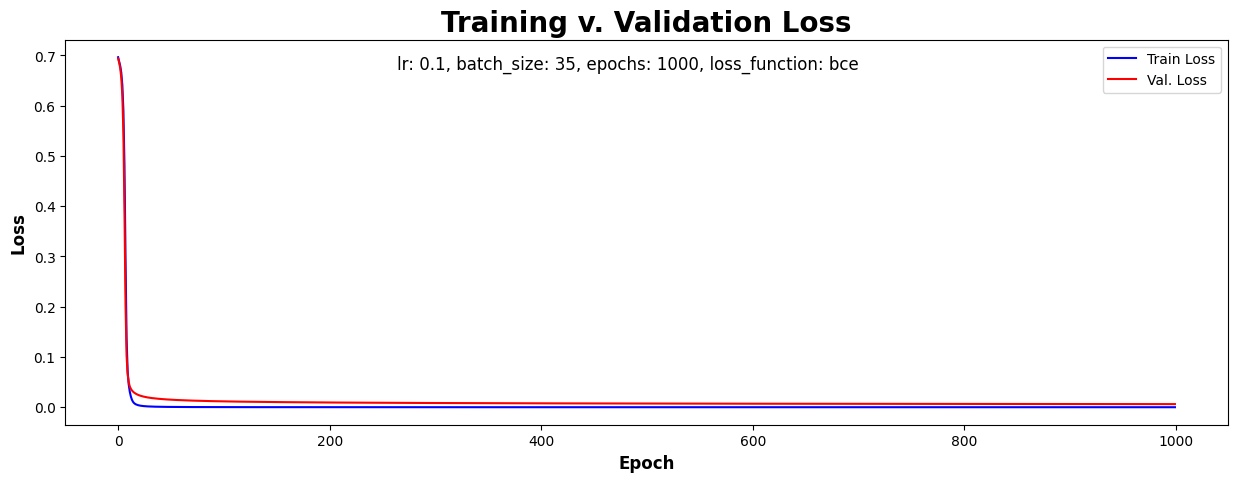

In [657]:
# plot loss
plt.rcParams["figure.figsize"] = (15,5)
sns.lineplot(data=loss_data_df, x="epoch", y="per_epoch_loss_train", label="Train Loss", color='blue')
sns.lineplot(data=loss_data_df, x="epoch", y="per_epoch_loss_val", label="Val. Loss", color='red')
plt.title(f"Training v. Validation Loss", weight='bold', fontsize='20')
plt.suptitle(f"lr: {lr}, batch_size: {batch_size}, epochs: {epochs}, loss_function: {loss_function}", fontsize=12, y=0.85)
plt.xlabel("Epoch", weight='bold', fontsize='12')
plt.ylabel("Loss", weight='bold', fontsize='12')
plt.show()


#### Average accuracy on validation set

__Note, how should we get accuracy instead of loss__

In [529]:
print("Average loss over the validation set: ", np.mean(per_epoch_loss_val))

Average loss over the validation set:  0.6949208514007843
